# QTM350 Final Project
Xinyue (Cindy) Zhang, Jiayin Li, Honggang (Peter) Min

Project Lighting Talk: https://drive.google.com/file/d/148A_IiZdJEtvBMISvdI50mLJ9ClsUh99/view?usp=sharing

##  ML Problem Framing
Explains a thorough, appropriate, and comprehensive definition of the problem in a machine learning context.
Incentives:
As a New York Yellow Taxi Driver, how can you maximize the tip you get?

It is not possible for you to decide 'where the consutomer to go', 'how far the ride is', or 'the number passengers you will pick up next'. However, you do have the right to pick what time you want your shift to be and what day of the week you want to work.

Based on this idea, we created two new binary attributes with the AWS open dataset of NYC Taxi: 'isNight' and 'isWeekend'. 

For the 'isNight' attribute, we classified shift time into "day" and "night".
For the 'isWeekend' attribute, we we classified shift day of the week into "weekend" and "weekday".
Both variables will be futher expained later.

To make it clear, we define the dependent variable to be whether "the driver’s tip is higher(equal)or lower than the monthly tip average".
If the trip's tip is higher than monthly tip, then Y = 1, else, Y = 0.


Goal: predict the mean for tip of one shift base on time(day/night & weekend/weekday). Classified those who earn above the average 1, otherwise 0.

Final Objective: An analysis of how yellow taxi drivers can maximize their total payout (tip amount) based on the prediction. 

In [144]:
# Setup Notebook Environment

import boto3
import botocore
import pandas as pd
from IPython.display import display, Markdown

import sagemaker
import sagemaker.amazon.common as smac
from sagemaker import get_execution_role
from sagemaker.predictor import csv_serializer, json_deserializer

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

import io
import matplotlib.pyplot as plt
import numpy as np 
import os

import sagemaker
import sagemaker.amazon.common as smac
from sagemaker import get_execution_role
from sagemaker.predictor import csv_serializer, json_deserializer

s3 = boto3.client('s3')
print(s3)
s3_resource = boto3.resource('s3')

# DATA

Our data is about the trips taken by yellow taxis in New York City. Official data info is on the AWS open data page: https://registry.opendata.aws/nyc-tlc-trip-records-pds/
We get the data by downloading the dataset from official AWS open data set's s3 bucket to our own s3 bucket follow the following steps:

In [145]:
# Creat Bucket

def create_bucket(bucket):
    import logging

    try:
        s3.create_bucket(Bucket=bucket)
    except botocore.exceptions.ClientError as e:
        logging.error(e)
        return 'Bucket ' + bucket + ' could not be created.'
    return 'Created or already exists ' + bucket + ' bucket.'

create_bucket('open-data-analytics-taxi-trips-zyl')

'Created or already exists open-data-analytics-taxi-trips-zyl bucket.'

In [146]:
# List Bucket

def list_buckets(match=''):
    response = s3.list_buckets()
    if match:
        print(f'Existing buckets containing "{match}" string:')
    else:
        print('All existing buckets:')
    for bucket in response['Buckets']:
        if match:
            if match in bucket["Name"]:
                print(f'  {bucket["Name"]}')
                      
list_buckets(match='open')

Existing buckets containing "open" string:
  open-data-analytics-taxi-trips-zyl


In [4]:
# List Bucket Contents

def list_bucket_contents(bucket, match='', size_mb=0):
    bucket_resource = s3_resource.Bucket(bucket)
    total_size_gb = 0
    total_files = 0
    match_size_gb = 0
    match_files = 0
    for key in bucket_resource.objects.all():
        key_size_mb = key.size/1024/1024
        total_size_gb += key_size_mb
        total_files += 1
        list_check = False
        if not match:
            list_check = True
        elif match in key.key:
            list_check = True
        if list_check and not size_mb:
            match_files += 1
            match_size_gb += key_size_mb
            print(f'{key.key} ({key_size_mb:3.0f}MB)')
        elif list_check and key_size_mb <= size_mb:
            match_files += 1
            match_size_gb += key_size_mb
            print(f'{key.key} ({key_size_mb:3.0f}MB)')

    if match:
        print(f'Matched file size is {match_size_gb/1024:3.1f}GB with {match_files} files')            
    
    print(f'Bucket {bucket} total size is {total_size_gb/1024:3.1f}GB with {total_files} files')
  
    
list_bucket_contents(bucket='nyc-tlc', match='2018', size_mb=250)




trip data/green_tripdata_2018-01.csv ( 68MB)
trip data/green_tripdata_2018-02.csv ( 66MB)
trip data/green_tripdata_2018-03.csv ( 71MB)
trip data/green_tripdata_2018-04.csv ( 68MB)
trip data/green_tripdata_2018-05.csv ( 68MB)
trip data/green_tripdata_2018-06.csv ( 63MB)
trip data/green_tripdata_2018-07.csv ( 58MB)
trip data/green_tripdata_2018-08.csv ( 57MB)
trip data/green_tripdata_2018-09.csv ( 57MB)
trip data/green_tripdata_2018-10.csv ( 61MB)
trip data/green_tripdata_2018-11.csv ( 56MB)
trip data/green_tripdata_2018-12.csv ( 59MB)
Matched file size is 0.7GB with 12 files
Bucket nyc-tlc total size is 285.5GB with 274 files


In [147]:
#  Copy Among Buckets

def key_exists(bucket, key):
    try:
        s3_resource.Object(bucket, key).load()
    except botocore.exceptions.ClientError as e:
        if e.response['Error']['Code'] == "404":
            # The key does not exist.
            return(False)
        else:
            # Something else has gone wrong.
            raise
    else:
        # The key does exist.
        return(True)

def copy_among_buckets(from_bucket, from_key, to_bucket, to_key):
    if not key_exists(to_bucket, to_key):
        s3_resource.meta.client.copy({'Bucket': from_bucket, 'Key': from_key}, 
                                        to_bucket, to_key)        
        print(f'File {to_key} saved to S3 bucket {to_bucket}')
    else:
        print(f'File {to_key} already exists in S3 bucket {to_bucket}') 

        
for i in range(1,13): 
    if i<10:
        fromkey='trip data/yellow_tripdata_2018-0'+str(i)+'.csv'
        tokey='yellow_tripdata_2018-0'+str(i)+'.csv'
    else:
        fromkey='trip data/yellow_tripdata_2018-'+str(i)+'.csv'
        tokey='yellow_tripdata_2018-'+str(i)+'.csv'
    copy_among_buckets(from_bucket='nyc-tlc', from_key=fromkey,
                      to_bucket='fp-zyl', to_key=tokey)

File yellow_tripdata_2018-01.csv already exists in S3 bucket fp-zyl
File yellow_tripdata_2018-02.csv already exists in S3 bucket fp-zyl
File yellow_tripdata_2018-03.csv already exists in S3 bucket fp-zyl
File yellow_tripdata_2018-04.csv already exists in S3 bucket fp-zyl
File yellow_tripdata_2018-05.csv already exists in S3 bucket fp-zyl
File yellow_tripdata_2018-06.csv already exists in S3 bucket fp-zyl
File yellow_tripdata_2018-07.csv already exists in S3 bucket fp-zyl
File yellow_tripdata_2018-08.csv already exists in S3 bucket fp-zyl
File yellow_tripdata_2018-09.csv already exists in S3 bucket fp-zyl
File yellow_tripdata_2018-10.csv already exists in S3 bucket fp-zyl
File yellow_tripdata_2018-11.csv already exists in S3 bucket fp-zyl
File yellow_tripdata_2018-12.csv already exists in S3 bucket fp-zyl


In [6]:
# Preview CSV Dataset

def preview_csv_dataset(bucket, key, rows=10):
    data_source = {
            'Bucket': bucket,
            'Key': key
        }
    # Generate the URL to get Key from Bucket
    url = s3.generate_presigned_url(
        ClientMethod = 'get_object',
        Params = data_source
    )

    data = pd.read_csv(url, nrows=rows)
    return data


df = preview_csv_dataset(bucket='nyc-tlc', key='trip data/yellow_tripdata_2018-01.csv', rows=100)

df.head()
df.shape
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 17 columns):
VendorID                 100 non-null int64
tpep_pickup_datetime     100 non-null object
tpep_dropoff_datetime    100 non-null object
passenger_count          100 non-null int64
trip_distance            100 non-null float64
RatecodeID               100 non-null int64
store_and_fwd_flag       100 non-null object
PULocationID             100 non-null int64
DOLocationID             100 non-null int64
payment_type             100 non-null int64
fare_amount              100 non-null float64
extra                    100 non-null float64
mta_tax                  100 non-null float64
tip_amount               100 non-null float64
tolls_amount             100 non-null float64
improvement_surcharge    100 non-null float64
total_amount             100 non-null float64
dtypes: float64(8), int64(6), object(3)
memory usage: 13.4+ KB


,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,100.000000,100.00000,100.000000,100.00,100.000000,100.000000,100.00000,100.000000,100.000000,100.00,100.000000,100.0000,100.000,100.000000
mean,1.420000,1.78000,2.335000,1.01,169.310000,163.510000,1.48000,11.110000,0.485000,0.49,1.333100,0.0576,0.294,13.769700
std,0.496045,1.33772,2.209747,0.10,73.621156,74.873698,0.55922,8.320165,0.111351,0.10,1.687668,0.5760,0.060,9.144411
min,1.000000,1.00000,0.000000,1.00,4.000000,4.000000,1.00000,-3.000000,-0.500000,-0.50,0.000000,0.0000,-0.300,-4.300000
25%,1.000000,1.00000,0.797500,1.00,140.750000,97.500000,1.00000,5.500000,0.500000,0.50,0.000000,0.0000,0.300,7.450000
50%,1.000000,1.00000,1.650000,1.00,164.000000,164.000000,1.00000,8.750000,0.500000,0.50,1.000000,0.0000,0.300,11.230000
75%,2.000000,2.00000,3.000000,1.00,236.000000,234.000000,2.00000,14.500000,0.500000,0.50,2.087500,0.0000,0.300,17.152500
max,2.000000,6.00000,10.900000,2.00,263.000000,264.000000,4.00000,52.000000,0.500000,0.50,9.080000,5.7600,0.300,52.800000


In [148]:
#download data to the notebook instance
for i in range(1,13):
    if i<10:
        raw_data_filename = 'trip data/yellow_tripdata_2018-0'+str(i)+'.csv'
    else:
        raw_data_filename = 'trip data/yellow_tripdata_2018-'+str(i)+'.csv'
    data_bucket = 'nyc-tlc'
    filename='raw_data2018'+str(i)+'.csv'
    s3 = boto3.resource('s3')
    s3.Bucket(data_bucket).download_file(raw_data_filename, filename)

    data = pd.read_csv('./'+filename)
#pd.set_option('display.max_rows', 20) 
data

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2018-12-01 00:28:22,2018-12-01 00:44:07,2,2.500,1,N,148,234,1,12.000,0.500,0.500,3.950,0.000,0.300,17.250
1,1,2018-12-01 00:52:29,2018-12-01 01:11:37,3,2.300,1,N,170,144,1,13.000,0.500,0.500,2.850,0.000,0.300,17.150
2,2,2018-12-01 00:12:52,2018-12-01 00:36:23,1,0.000,1,N,113,193,2,2.500,0.500,0.500,0.000,0.000,0.300,3.800
3,1,2018-12-01 00:35:08,2018-12-01 00:43:11,1,3.900,1,N,95,92,1,12.500,0.500,0.500,2.750,0.000,0.300,16.550
4,1,2018-12-01 00:21:54,2018-12-01 01:15:13,1,12.800,1,N,163,228,1,45.000,0.500,0.500,9.250,0.000,0.300,55.550
5,1,2018-12-01 00:00:38,2018-12-01 00:29:26,1,18.800,1,N,132,97,1,50.500,0.500,0.500,10.350,0.000,0.300,62.150
6,1,2018-12-01 00:59:39,2018-12-01 01:09:07,1,1.000,1,N,246,164,1,7.500,0.500,0.500,0.440,0.000,0.300,9.240
7,1,2018-12-01 00:19:19,2018-12-01 00:22:19,1,0.300,1,N,161,163,4,4.000,0.500,0.500,0.000,0.000,0.300,5.300
8,1,2018-12-01 00:41:41,2018-12-01 01:09:02,1,3.300,1,N,43,146,2,17.500,0.500,0.500,0.000,0.000,0.300,18.800
9,1,2018-12-01 00:16:03,2018-12-01 00:52:42,1,5.700,1,N,161,223,1,26.500,0.500,0.500,5.550,0.000,0.300,33.350


In [66]:
# read data
data1 = pd.read_csv('./raw_data20181.csv',usecols=['tpep_pickup_datetime','passenger_count','trip_distance','fare_amount','tip_amount','total_amount','payment_type'])
# data2 = pd.read_csv('./raw_data20182.csv',usecols=['passenger_count','trip_distance','fare_amount','tip_amount','total_amount'])
# data3 = pd.read_csv('./raw_data20183.csv',usecols=['passenger_count','trip_distance','fare_amount','tip_amount','total_amount'])
# data4 = pd.read_csv('./raw_data20184.csv',usecols=['passenger_count','trip_distance','fare_amount','tip_amount','total_amount'])
# data5 = pd.read_csv('./raw_data20185.csv',usecols=['passenger_count','trip_distance','fare_amount','tip_amount','total_amount'])
# data6 = pd.read_csv('./raw_data20186.csv',usecols=['passenger_count','trip_distance','fare_amount','tip_amount','total_amount'])
# data7 = pd.read_csv('./raw_data20187.csv',usecols=['passenger_count','trip_distance','fare_amount','tip_amount','total_amount'])
# data8 = pd.read_csv('./raw_data20188.csv',usecols=['passenger_count','trip_distance','fare_amount','tip_amount','total_amount'])
# data9 = pd.read_csv('./raw_data20189.csv',usecols=['passenger_count','trip_distance','fare_amount','tip_amount','total_amount'])
# data10 = pd.read_csv('./raw_data201810.csv',usecols=['passenger_count','trip_distance','fare_amount','tip_amount','total_amount'])
# data11 = pd.read_csv('./raw_data201811.csv',usecols=['passenger_count','trip_distance','fare_amount','tip_amount','total_amount'])
# data12 = pd.read_csv('./raw_data201812.csv',usecols=['passenger_count','trip_distance','fare_amount','tip_amount','total_amount'])


In [28]:
data1

,tpep_pickup_datetime,passenger_count,trip_distance,fare_amount,tip_amount,total_amount,tip_percent
0,2018-01-01 00:21:05,1,0.50,4.50,0.00,5.80,0.000000
4256908,2018-01-16 23:05:13,1,0.84,4.50,0.00,5.80,0.000000
4256910,2018-01-16 23:48:44,6,1.19,6.50,0.00,7.80,0.000000
4256914,2018-01-16 23:55:54,1,1.25,6.50,0.00,7.80,0.000000
4256918,2018-01-16 23:16:20,5,0.39,4.00,0.00,5.30,0.000000
4256919,2018-01-16 23:21:50,5,1.23,6.00,0.00,7.30,0.000000
4256925,2018-01-16 23:13:51,1,9.52,27.00,0.00,28.30,0.000000
4256930,2018-01-16 23:48:26,1,3.80,15.00,0.00,16.30,0.000000
4256932,2018-01-16 23:10:33,1,0.41,4.00,0.00,5.30,0.000000
4256938,2018-01-16 23:34:16,1,2.10,9.00,0.00,10.30,0.000000


In [25]:
#get a general idea about the data distribution
data1[['passenger_count','trip_distance','fare_amount','tip_amount','total_amount']].describe()

,passenger_count,trip_distance,fare_amount,tip_amount,total_amount
count,8.759874e+06,8.759874e+06,8.759874e+06,8.759874e+06,8.759874e+06
mean,1.606855e+00,2.804001e+00,1.224434e+01,1.818745e+00,1.549098e+01
std,1.258464e+00,6.412346e+01,1.168321e+01,2.486341e+00,1.419540e+01
min,0.000000e+00,0.000000e+00,-4.500000e+02,-8.880000e+01,-4.503000e+02
25%,1.000000e+00,9.100000e-01,6.000000e+00,0.000000e+00,8.300000e+00
50%,1.000000e+00,1.550000e+00,9.000000e+00,1.360000e+00,1.130000e+01
75%,2.000000e+00,2.840000e+00,1.350000e+01,2.350000e+00,1.662000e+01
max,9.000000e+00,1.894838e+05,8.016000e+03,4.417100e+02,8.016800e+03




We here used January data as an example to rank the dataframe base on tip amount, and we found that there are negative numbers, which does not make sense since drivers would never tip back to their customers.



In [67]:
# using January data as an example to rank the df base on tip amount, and we found that there are negative numbers, which does not make sense
data1["Rank"] = data1["tip_amount"].rank()
data1.sort_values("tip_amount", inplace = True) #reordered: least on top
data1

,tpep_pickup_datetime,passenger_count,trip_distance,payment_type,fare_amount,tip_amount,total_amount,Rank
5300576,2018-01-20 10:18:32,1,0.81,3,-4.5,-88.80,-94.10,1.0
7849715,2018-01-28 21:34:35,2,0.00,3,-65.0,-13.06,-78.36,2.0
6210621,2018-01-23 17:18:30,1,0.36,4,-4.0,-11.00,-16.80,3.0
3575694,2018-01-14 14:25:45,5,0.75,4,-4.5,-10.00,-15.30,4.0
2562900,2018-01-11 10:21:16,1,0.68,3,-52.0,-7.92,-60.72,5.0
5555849,2018-01-21 02:01:48,1,0.00,3,-13.0,-3.32,-16.62,6.0
2210176,2018-01-10 06:59:44,1,0.00,4,-2.5,-3.00,-6.30,7.0
3912075,2018-01-15 19:43:33,1,0.00,3,-2.5,-2.30,-5.60,8.0
5153327,2018-01-19 20:06:53,1,0.00,3,-2.5,-2.00,-5.80,9.5
1001180,2018-01-05 16:40:16,1,0.00,3,-2.5,-2.00,-6.30,9.5


Similarly, we also deleted some data that does not make sense, including negative fare amount, total amount, the number of passengers and trip distance. In this way, our dataset became more reasonable and realistic, so that our model later could be more accurate and significant for future use.

In [68]:
#drop rows w negative tip_amount

data1 = data1[(data1['fare_amount']>0)]  #delete negative rows
data1 = data1[(data1['tip_amount']>=0)] 
data1 = data1[(data1['total_amount']>0)] 
data1 = data1[(data1['passenger_count']>0)] 
data1 = data1[(data1['trip_distance']>0)] 

In [69]:
data1['tip_percent'] = data1['tip_amount']/data1['fare_amount']
data1.sort_values("tip_percent", inplace = True)
data1[['passenger_count','trip_distance','fare_amount','tip_amount','total_amount']].describe()

,passenger_count,trip_distance,fare_amount,tip_amount,total_amount
count,8.641672e+06,8.641672e+06,8.641672e+06,8.641672e+06,8.641672e+06
mean,1.619278e+00,2.823534e+00,1.219387e+01,1.813055e+00,1.543502e+01
std,1.257139e+00,6.455868e+01,1.108265e+01,2.420130e+00,1.363849e+01
min,1.000000e+00,1.000000e-02,1.000000e-02,0.000000e+00,3.100000e-01
25%,1.000000e+00,9.300000e-01,6.500000e+00,0.000000e+00,8.300000e+00
50%,1.000000e+00,1.570000e+00,9.000000e+00,1.400000e+00,1.130000e+01
75%,2.000000e+00,2.870000e+00,1.350000e+01,2.350000e+00,1.662000e+01
max,9.000000e+00,1.894838e+05,8.016000e+03,4.417100e+02,8.016800e+03


In [70]:
data1["date"] = [date[0:10] for date in data1["tpep_pickup_datetime"]]
data1["time"] = [date[11:] for date in data1["tpep_pickup_datetime"]]

data1["Rank"] = data1["time"].rank() 

data1.sort_values("time", inplace = True)

data1 = data1.dropna()
data1



,tpep_pickup_datetime,passenger_count,trip_distance,payment_type,fare_amount,tip_amount,total_amount,Rank,tip_percent,date,time
2469978,2018-01-10 00:00:00,1,22.28,2,52.0,0.00,58.56,63.5,0.000000,2018-01-10,00:00:00
2158535,2018-01-09 00:00:00,1,18.49,1,50.0,7.70,59.00,63.5,0.154000,2018-01-09,00:00:00
7623170,2018-01-28 00:00:00,1,1.91,1,11.0,3.00,15.30,63.5,0.272727,2018-01-28,00:00:00
1485944,2018-01-07 00:00:00,1,1.06,2,6.5,0.00,7.30,63.5,0.000000,2018-01-07,00:00:00
6789112,2018-01-25 00:00:00,5,2.80,1,14.0,2.22,17.02,63.5,0.158571,2018-01-25,00:00:00
1182801,2018-01-06 00:00:00,2,2.80,1,10.5,1.70,13.00,63.5,0.161905,2018-01-06,00:00:00
1913056,2018-01-09 00:00:00,1,1.30,1,7.0,2.49,10.79,63.5,0.355714,2018-01-09,00:00:00
5331252,2018-01-20 00:00:00,2,1.69,2,9.0,0.00,9.80,63.5,0.000000,2018-01-20,00:00:00
5369427,2018-01-20 00:00:00,1,6.50,2,19.5,0.00,20.30,63.5,0.000000,2018-01-20,00:00:00
744761,2018-01-04 00:00:00,2,2.59,1,10.0,2.26,13.56,63.5,0.226000,2018-01-04,00:00:00


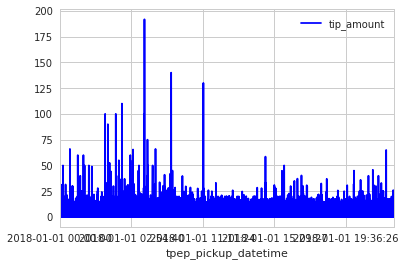

In [44]:
df1 = data1

df1['tpep_pickup_datetime'][0][0:10]

Jan_01_18 = df1[(df1['tpep_pickup_datetime'].str[0:10] == "2018-01-01")]

Jan_01_18.plot(x = 'tpep_pickup_datetime', y = 'tip_amount', color = 'blue')

plt.show()

In [ ]:
# Check Trend

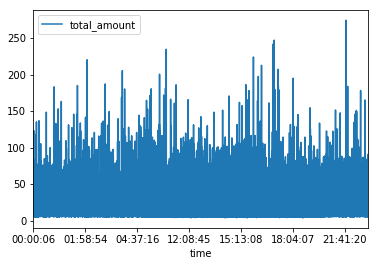

In [32]:
jan_01_18 = data1[(data1["tip_amount"] > 0) & (data1["date"] == "2018-01-01")]



jan_01_18.plot(x = "time", y = "total_amount")
plt.show()

According to the graph that we made above, we assumed that there might be some differences of the tip amount that the drivers get between driving at daytime and nighttime, since from the graph, the y axis in the middle of the day seems to be lower. Therefore, we set up a new variable ‘DayNight’, with 20:00~05:00 to be the day shift, and 5:00~20:00 to be the night shift. We did this by making a loop and filtering the time variable that we separated from “tpep_pickup_datetime’.

In [71]:
section=[]

for date_str in data1["tpep_pickup_datetime"]:
    time = int(date_str[11:13])
    #print(time)
    if (time>=0 and time<5) or time>=20:
        sec = 'night'
    else:
        sec = 'day'
#     elif time>=6 and time<=11:
#         sec = 2
#     elif time>=12 and time<23:
#         sec = 3
    #print(sec)
    section.append(sec)
#print("se")
data1.insert(0,'DayNight',section)
data1

,DayNight,tpep_pickup_datetime,passenger_count,trip_distance,payment_type,fare_amount,tip_amount,total_amount,Rank,tip_percent,date,time
2469978,night,2018-01-10 00:00:00,1,22.28,2,52.0,0.00,58.56,63.5,0.000000,2018-01-10,00:00:00
2158535,night,2018-01-09 00:00:00,1,18.49,1,50.0,7.70,59.00,63.5,0.154000,2018-01-09,00:00:00
7623170,night,2018-01-28 00:00:00,1,1.91,1,11.0,3.00,15.30,63.5,0.272727,2018-01-28,00:00:00
1485944,night,2018-01-07 00:00:00,1,1.06,2,6.5,0.00,7.30,63.5,0.000000,2018-01-07,00:00:00
6789112,night,2018-01-25 00:00:00,5,2.80,1,14.0,2.22,17.02,63.5,0.158571,2018-01-25,00:00:00
1182801,night,2018-01-06 00:00:00,2,2.80,1,10.5,1.70,13.00,63.5,0.161905,2018-01-06,00:00:00
1913056,night,2018-01-09 00:00:00,1,1.30,1,7.0,2.49,10.79,63.5,0.355714,2018-01-09,00:00:00
5331252,night,2018-01-20 00:00:00,2,1.69,2,9.0,0.00,9.80,63.5,0.000000,2018-01-20,00:00:00
5369427,night,2018-01-20 00:00:00,1,6.50,2,19.5,0.00,20.30,63.5,0.000000,2018-01-20,00:00:00
744761,night,2018-01-04 00:00:00,2,2.59,1,10.0,2.26,13.56,63.5,0.226000,2018-01-04,00:00:00


Furthermore, according to the other graph above, we found that there have been some differences on the tip amount on different date, and we then suggested that this might be related to driving on weekday or weekends. Hence, we made another new variable ‘Week’ so that we could make a model to check if our guess is accurate. 



In [78]:
weekend = []

for date in data1["date"]:
    date_time_obj = datetime.strptime(date, '%Y-%m-%d')
    
    weekno = date_time_obj.weekday()

    if weekno<5:
        sec = 'weekday'
    else:
        sec = 'weekend'
    weekend.append(sec)
#print("se")
data1.insert(0,'Week',weekend)
data1

,Week,DayNight,tpep_pickup_datetime,passenger_count,trip_distance,payment_type,fare_amount,tip_amount,total_amount,Rank,tip_percent,date,time
2469978,weekday,night,2018-01-10 00:00:00,1,22.28,2,52.0,0.00,58.56,63.5,0.000000,2018-01-10,00:00:00
2158535,weekday,night,2018-01-09 00:00:00,1,18.49,1,50.0,7.70,59.00,63.5,0.154000,2018-01-09,00:00:00
7623170,weekend,night,2018-01-28 00:00:00,1,1.91,1,11.0,3.00,15.30,63.5,0.272727,2018-01-28,00:00:00
1485944,weekend,night,2018-01-07 00:00:00,1,1.06,2,6.5,0.00,7.30,63.5,0.000000,2018-01-07,00:00:00
6789112,weekday,night,2018-01-25 00:00:00,5,2.80,1,14.0,2.22,17.02,63.5,0.158571,2018-01-25,00:00:00
1182801,weekend,night,2018-01-06 00:00:00,2,2.80,1,10.5,1.70,13.00,63.5,0.161905,2018-01-06,00:00:00
1913056,weekday,night,2018-01-09 00:00:00,1,1.30,1,7.0,2.49,10.79,63.5,0.355714,2018-01-09,00:00:00
5331252,weekend,night,2018-01-20 00:00:00,2,1.69,2,9.0,0.00,9.80,63.5,0.000000,2018-01-20,00:00:00
5369427,weekend,night,2018-01-20 00:00:00,1,6.50,2,19.5,0.00,20.30,63.5,0.000000,2018-01-20,00:00:00
744761,weekday,night,2018-01-04 00:00:00,2,2.59,1,10.0,2.26,13.56,63.5,0.226000,2018-01-04,00:00:00


Here, we wanted to set up a binary variable, which could be our Y value later in the model. We first calculated the mean value of the tip amount in the whole dataset, and defined the ones that are the same as or higher than the mean value to be 1, and others to be 0. 



In [85]:
meanTip = data1['tip_amount'].mean()
islager = []

for tip in data1["tip_amount"]:
    if tip >= meanTip :
        sec = 1
    else:
        sec = 0
        
    islager.append(sec)
#print("se")
data1.insert(0,'Y',islager)
data1   

ValueError: cannot insert Y, already exists

In [86]:
data1

,Y,Week,DayNight,tpep_pickup_datetime,passenger_count,trip_distance,payment_type,fare_amount,tip_amount,total_amount,Rank,tip_percent,date,time
2469978,0,weekday,night,2018-01-10 00:00:00,1,22.28,2,52.0,0.00,58.56,63.5,0.000000,2018-01-10,00:00:00
2158535,1,weekday,night,2018-01-09 00:00:00,1,18.49,1,50.0,7.70,59.00,63.5,0.154000,2018-01-09,00:00:00
7623170,1,weekend,night,2018-01-28 00:00:00,1,1.91,1,11.0,3.00,15.30,63.5,0.272727,2018-01-28,00:00:00
1485944,0,weekend,night,2018-01-07 00:00:00,1,1.06,2,6.5,0.00,7.30,63.5,0.000000,2018-01-07,00:00:00
6789112,1,weekday,night,2018-01-25 00:00:00,5,2.80,1,14.0,2.22,17.02,63.5,0.158571,2018-01-25,00:00:00
1182801,0,weekend,night,2018-01-06 00:00:00,2,2.80,1,10.5,1.70,13.00,63.5,0.161905,2018-01-06,00:00:00
1913056,1,weekday,night,2018-01-09 00:00:00,1,1.30,1,7.0,2.49,10.79,63.5,0.355714,2018-01-09,00:00:00
5331252,0,weekend,night,2018-01-20 00:00:00,2,1.69,2,9.0,0.00,9.80,63.5,0.000000,2018-01-20,00:00:00
5369427,0,weekend,night,2018-01-20 00:00:00,1,6.50,2,19.5,0.00,20.30,63.5,0.000000,2018-01-20,00:00:00
744761,1,weekday,night,2018-01-04 00:00:00,2,2.59,1,10.0,2.26,13.56,63.5,0.226000,2018-01-04,00:00:00


To create more useful variables, we changed both our “Week” and “DayNight” into binary.
We also created a new dataframe “inputDF” to reduce error and easy to use.


In [91]:
inputDF = data1[['Y','DayNight','Week']]

In [94]:
inputDF 
isNight = []
for val in inputDF["DayNight"]:
    if val == 'night':
        sec = 1
    else:
        sec = 0
    isNight.append(sec)
#print("se")
inputDF.insert(0,'isNight',isNight)
inputDF


,isNight,Y,DayNight,Week
2469978,1,0,night,weekday
2158535,1,1,night,weekday
7623170,1,1,night,weekend
1485944,1,0,night,weekend
6789112,1,1,night,weekday
1182801,1,0,night,weekend
1913056,1,1,night,weekday
5331252,1,0,night,weekend
5369427,1,0,night,weekend
744761,1,1,night,weekday


In [95]:
inputDF 
isWeekend = []
for val in inputDF["Week"]:


    if val == 'weekend':
        sec = 1
    else:
        sec = 0
    isWeekend.append(sec)
#print("se")
inputDF.insert(0,'isWeekend',isWeekend)
inputDF

,isWeekend,isNight,Y,DayNight,Week
2469978,0,1,0,night,weekday
2158535,0,1,1,night,weekday
7623170,1,1,1,night,weekend
1485944,1,1,0,night,weekend
6789112,0,1,1,night,weekday
1182801,1,1,0,night,weekend
1913056,0,1,1,night,weekday
5331252,1,1,0,night,weekend
5369427,1,1,0,night,weekend
744761,0,1,1,night,weekday


In [48]:
tip_avg = data1.groupby('Section')['tip_percent','tip_amount','passenger_count','trip_distance','fare_amount','total_amount'].describe()
tip_avg
tip_avg2 = data1.groupby('Section2')['tip_percent','tip_amount','passenger_count','trip_distance','fare_amount','total_amount'].describe()
tip_avg2

tip_percent                                                    \
               count      mean       std  min  25%       50%       75%   
Section2                                                                 
resttime   3624090.0  0.157349  2.653446  0.0  0.0  0.208929  0.236901   
worktime   5017582.0  0.157571  8.257742  0.0  0.0  0.204156  0.229091   

                  tip_amount            ... fare_amount         total_amount  \
              max      count      mean  ...         75%     max        count   
Section2                                ...                                    
resttime   5000.0  3624090.0  1.867912  ...        14.0  8016.0    3624090.0   
worktime  10000.0  5017582.0  1.773433  ...        13.0  3013.5    5017582.0   

                                                                 
               mean        std   min   25%    50%   75%     max  
Section2                                                         
resttime  15.743352  13.810383  0.31  8.30  11.75  17.3  8016.8  
worktime  15.212323  13.508602  0.31  8.16  11.16  16.3  3014.3  

[2 rows x 48 columns]

[(0, 5)]

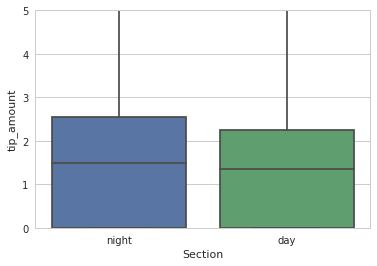

In [49]:
sns.set(style="whitegrid")
tips = sns.load_dataset("tips")
# ax = sns.boxplot(x=tips["total_bill"])

ax = sns.boxplot(x="Section", y="tip_amount", data=data1)
ax.set(ylim=(0, 5))



In [79]:
bucket = 'fp-zyl'                       
prefix = 'sagemaker/linear-loss-SGD'   
s3_train_key = '{}/train/recordio-pb-data'.format(prefix)
s3_train_path = os.path.join('s3://', bucket, s3_train_key)

role = get_execution_role()

In [96]:
# Confirm access to s3 bucket

# for obj in boto3.resource('s3').Bucket(bucket).objects.all():
#     print(obj.key)
inputDF

,isWeekend,isNight,Y,DayNight,Week
2469978,0,1,0,night,weekday
2158535,0,1,1,night,weekday
7623170,1,1,1,night,weekend
1485944,1,1,0,night,weekend
6789112,0,1,1,night,weekday
1182801,1,1,0,night,weekend
1913056,0,1,1,night,weekday
5331252,1,1,0,night,weekend
5369427,1,1,0,night,weekend
744761,0,1,1,night,weekday


When it comes to the model training part, we used the default setting, where we used 70% of the data as the training set, the other rest of the 30% as the test set, in the linear learner notebook.

In [110]:
inputDF['isWeekend'] = inputDF['isWeekend'].astype('float64')
inputDF['isNight'] = inputDF['isNight'].astype('float64')



currentData = inputDF.as_matrix()
np.random.seed(0)
np.random.shuffle(currentData)
train_size = int(currentData.shape[0] * 0.7)
train_features  = currentData[:train_size, 0:2]
train_labels = currentData[:train_size, 2]
test_features = currentData[train_size:, 0:2]
test_labels = currentData[train_size:, 2]

# train_features
# Convert the processed training data to protobuf and write to S3 for linear learner
vectors = np.array([t for t in train_features]).astype('float32')
labels = np.array([t for t in train_labels]).astype('float32')
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, vectors, labels)
buf.seek(0)
boto3.resource('s3').Bucket(bucket).Object(s3_train_key).upload_fileobj(buf)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


This is the model training setup function.

In [116]:
from sagemaker.amazon.amazon_estimator import get_image_uri

def predictor_from_hyperparams(s3_train_data, hyperparams, output_path):
    """
    Create an Estimator from the given hyperparams, fit to training data, and return a deployed predictor
    """
    # specify algorithm containers and instantiate an Estimator with given hyperparams
    container = get_image_uri(boto3.Session().region_name, 'linear-learner')

    linear = sagemaker.estimator.Estimator(container,
        role,
        train_instance_count=1,
        train_instance_type='ml.c5.9xlarge',
        output_path=output_path,
        sagemaker_session=sagemaker.Session())
    linear.set_hyperparameters(**hyperparams)
    # train model
    linear.fit({'train': s3_train_data})
    # deploy a predictor
    linear_predictor = linear.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
    linear_predictor.content_type = 'text/csv'
    linear_predictor.serializer = csv_serializer
    linear_predictor.deserializer = json_deserializer
    return linear_predictor

This is the function for evaluating the parameters of a model.

In [139]:
def evaluate(linear_predictor, test_features, test_labels, model_name, verbose=True):
    """
    Evaluate a model on a test set given the prediction endpoint.  Return binary classification metrics.
    """
    # split the test data set into 100 batches and evaluate using prediction endpoint
    prediction_batches = [linear_predictor.predict(batch)['predictions'] for batch in np.array_split(test_features, 100)]
    # parse raw predictions json to exctract predicted label
    test_preds = np.concatenate([np.array([x['predicted_label'] for x in batch]) for batch in prediction_batches])
    
    # calculate true positives, false positives, true negatives, false negatives
    tp = np.logical_and(test_labels, test_preds).sum()
    fp = np.logical_and(1-test_labels, test_preds).sum()
    tn = np.logical_and(1-test_labels, 1-test_preds).sum()
    fn = np.logical_and(test_labels, 1-test_preds).sum()
    
    # calculate binary classification metrics
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    f1 = 2 * precision * recall / (precision + recall)
    
    if verbose:
        print(pd.crosstab(test_labels, test_preds, rownames=['actuals'], colnames=['predictions']))
        print("\n{:<11} {:.3f}".format('Recall:', recall))
        print("{:<11} {:.3f}".format('Precision:', precision))
        print("{:<11} {:.3f}".format('Accuracy:', accuracy))
        print("{:<11} {:.3f}".format('F1:', f1))
        
    return {'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn, 'Precision': precision, 
            'Recall': recall, 'Accuracy': accuracy, 
            'F1': f1, 
            'Model': model_name}

In [113]:
def delete_endpoint(predictor):
        try:
            boto3.client('sagemaker').delete_endpoint(EndpointName=predictor.endpoint)
            print('Deleted {}'.format(predictor.endpoint))
        except:
            print('Already deleted: {}'.format(predictor.endpoint))

We chose logistic regression due to the nature of our problem of interest. We would like to see how does the model predict whether a taxi driver receives a tip amount that is above the average tip amount that the population exhibits or not. This leaves us a perfect opportunity to apply logistic regression since our feature, also known as the dependent variable, is a binary variable, taking the only value of either 1 or 0. 

In [115]:
# Training a binary classifier with default settings: logistic regression
defaults_hyperparams = {
    'feature_dim': 2,
    'predictor_type': 'binary_classifier',
    'epochs': 10
}
defaults_output_path = 's3://{}/{}/defaults/output'.format(bucket, prefix)
defaults_predictor = predictor_from_hyperparams(s3_train_path, defaults_hyperparams, defaults_output_path)

2019-12-09 05:37:38 Starting - Starting the training job...
2019-12-09 05:37:39 Starting - Launching requested ML instances......
2019-12-09 05:38:47 Starting - Preparing the instances for training......
2019-12-09 05:39:47 Downloading - Downloading input data...
2019-12-09 05:40:28 Training - Downloading the training image..Docker entrypoint called with argument(s): train
[12/09/2019 05:40:49 INFO 140431902009152] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': u'uniform', u'init_sigma': u'0.01', u'lr_scheduler_minimum_lr': u

[2019-12-09 05:46:57.823] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 5, "duration": 184270, "num_examples": 6050, "num_bytes": 314556840}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.6660607022830801, "sum": 0.6660607022830801, "min": 0.6660607022830801}}, "EndTime": 1575870417.824087, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 1}, "StartTime": 1575870417.82399}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.6661476052666246, "sum": 0.6661476052666246, "min": 0.6661476052666246}}, "EndTime": 1575870417.824193, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 1}, "StartTime": 1575870417.824171}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.6660633002375942, "sum

[2019-12-09 05:50:03.541] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 7, "duration": 185708, "num_examples": 6050, "num_bytes": 314556840}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.6660605334248656, "sum": 0.6660605334248656, "min": 0.6660605334248656}}, "EndTime": 1575870603.541747, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1575870603.541638}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.6661087811558793, "sum": 0.6661087811558793, "min": 0.6661087811558793}}, "EndTime": 1575870603.541836, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1575870603.541815}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.6660633007421003, "su

[2019-12-09 05:53:09.179] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 9, "duration": 185621, "num_examples": 6050, "num_bytes": 314556840}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.6660605191069805, "sum": 0.6660605191069805, "min": 0.6660605191069805}}, "EndTime": 1575870789.180147, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1575870789.180026}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.6660863140634041, "sum": 0.6660863140634041, "min": 0.6660863140634041}}, "EndTime": 1575870789.180314, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1575870789.180288}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.6660633009338127, "su

[2019-12-09 05:56:12.121] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 11, "duration": 182924, "num_examples": 6050, "num_bytes": 314556840}
#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.6660605142839016, "sum": 0.6660605142839016, "min": 0.6660605142839016}}, "EndTime": 1575870972.121721, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1575870972.121623}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.6660737636551658, "sum": 0.6660737636551658, "min": 0.6660737636551658}}, "EndTime": 1575870972.1218, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1575870972.121786}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.6660633009338127, "sum

[2019-12-09 05:56:30.727] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 16, "duration": 18590, "num_examples": 6050, "num_bytes": 314556840}
[2019-12-09 05:56:53.377] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 18, "duration": 20651, "num_examples": 6050, "num_bytes": 314556840}
[12/09/2019 05:56:53 INFO 140431902009152] #train_score (algo-1) : ('binary_classification_cross_entropy_objective', 0.6660646052747393)
[12/09/2019 05:56:53 INFO 140431902009152] #train_score (algo-1) : ('binary_classification_accuracy', 0.6120975274293828)
[12/09/2019 05:56:53 INFO 140431902009152] #train_score (algo-1) : ('binary_f_1.000', 0.0)
[12/09/2019 05:56:53 INFO 140431902009152] #train_score (algo-1) : ('precision', nan)
[12/09/2019 05:56:53 INFO 140431902009152] #train_score (algo-1) : ('recall', 0.0)
[12/09/2019 05:56:53 INFO 140431902009152] #quality_metric: host=algo-1, train binary_classification_cross_entropy_object

While we were trying to examine the results for the default logistic regression, there existed an error where precision cannot be calculated due to *float divided by 0*. Therefore, we employed binary classifier with class weights for our next step. This time, it also gave us some interesting results. 

In [117]:
# Training a binary classifier with class weights and automated threshold tuning
class_weights_hyperparams = {
    'feature_dim': 2,
    'predictor_type': 'binary_classifier',
    'binary_classifier_model_selection_criteria': 'precision_at_target_recall', 
    'target_recall': 0.9,
    'positive_example_weight_mult': 'balanced',
    'epochs': 30
}
class_weights_output_path = 's3://{}/{}/class_weights/output'.format(bucket, prefix)
class_weights_predictor = predictor_from_hyperparams(s3_train_path, class_weights_hyperparams, class_weights_output_path)

2019-12-09 06:06:15 Starting - Starting the training job...
2019-12-09 06:06:17 Starting - Launching requested ML instances......
2019-12-09 06:07:24 Starting - Preparing the instances for training............
2019-12-09 06:09:39 Downloading - Downloading input data
2019-12-09 06:09:39 Training - Downloading the training image..Docker entrypoint called with argument(s): train
[12/09/2019 06:09:55 INFO 140494632019776] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': u'uniform', u'init_sigma': u'0.01', u'lr_scheduler_minimum_lr'

[2019-12-09 06:13:12.602] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 5, "duration": 99142, "num_examples": 6050, "num_bytes": 314556840}
#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.834380998003205, "sum": 0.834380998003205, "min": 0.834380998003205}}, "EndTime": 1575871992.602748, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 1}, "StartTime": 1575871992.602695}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.834491566311645, "sum": 0.834491566311645, "min": 0.834491566311645}}, "EndTime": 1575871992.602798, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 1}, "StartTime": 1575871992.60279}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.83

[2019-12-09 06:14:50.433] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 7, "duration": 97823, "num_examples": 6050, "num_bytes": 314556840}
#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.83438078330556, "sum": 0.83438078330556, "min": 0.83438078330556}}, "EndTime": 1575872090.434048, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1575872090.433996}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.834442166803139, "sum": 0.834442166803139, "min": 0.834442166803139}}, "EndTime": 1575872090.4341, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1575872090.434092}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.834384

[2019-12-09 06:16:29.291] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 9, "duration": 98853, "num_examples": 6050, "num_bytes": 314556840}
#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.8343807633069354, "sum": 0.8343807633069354, "min": 0.8343807633069354}}, "EndTime": 1575872189.291939, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1575872189.291887}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.8344135619895204, "sum": 0.8344135619895204, "min": 0.8344135619895204}}, "EndTime": 1575872189.291991, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1575872189.291983}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max

[2019-12-09 06:18:03.052] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 11, "duration": 93749, "num_examples": 6050, "num_bytes": 314556840}
#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.834380757787638, "sum": 0.834380757787638, "min": 0.834380757787638}}, "EndTime": 1575872283.052863, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1575872283.052807}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max": 0.8343976143981863, "sum": 0.8343976143981863, "min": 0.8343976143981863}}, "EndTime": 1575872283.052914, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1575872283.052906}

#metrics {"Metrics": {"train_binary_classification_weighted_cross_entropy_objective": {"count": 1, "max":

[2019-12-09 06:18:14.717] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 16, "duration": 11645, "num_examples": 6050, "num_bytes": 314556840}
[2019-12-09 06:18:28.735] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 18, "duration": 12314, "num_examples": 6050, "num_bytes": 314556840}
[12/09/2019 06:18:28 INFO 140494632019776] #train_score (algo-1) : ('binary_classification_weighted_cross_entropy_objective', 0.8343861437185272)
[12/09/2019 06:18:28 INFO 140494632019776] #train_score (algo-1) : ('binary_classification_accuracy', 0.3879024725706171)
[12/09/2019 06:18:28 INFO 140494632019776] #train_score (algo-1) : ('binary_f_1.000', 0.5589765566915661)
[12/09/2019 06:18:28 INFO 140494632019776] #train_score (algo-1) : ('precision', 0.3879024725706171)
[12/09/2019 06:18:28 INFO 140494632019776] #train_score (algo-1) : ('recall', 1.0)
[12/09/2019 06:18:28 INFO 140494632019776] #quality_metric: host=algo-1, train bin

Next, we examined the hinge loss, also known as the SVM (Support Vector Machine) model because we think that our focus of this project is to gain better accuracy, precision and possibly recall values. Therefore, according to the introduction page in the lienar learner notebook, hinge loss was taken into consideration.

In [142]:
# Hinge Loss
hinge_loss_hyperparams = {
    'feature_dim': 2,
    'predictor_type': 'binary_classifier',
    'loss': 'hinge_loss',
    'margin': 1.0,
    'binary_classifier_model_selection_criteria': 'recall_at_target_precision', 
    'target_recall': 0.8,
    'epochs': 30
}
hinge_loss_output_path = 's3://{}/{}/class_weights/output'.format(bucket, prefix)
hinge_loss_predictor = predictor_from_hyperparams(s3_train_path, hinge_loss_hyperparams, hinge_loss_output_path)

2019-12-09 07:37:50 Starting - Starting the training job...
2019-12-09 07:37:51 Starting - Launching requested ML instances.........
2019-12-09 07:39:26 Starting - Preparing the instances for training...
2019-12-09 07:40:16 Downloading - Downloading input data
2019-12-09 07:40:16 Training - Downloading the training image..Docker entrypoint called with argument(s): train
[12/09/2019 07:40:31 INFO 139896882931520] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': u'uniform', u'init_sigma': u'0.01', u'lr_scheduler_minimum_lr': u'au

[2019-12-09 07:43:45.896] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 5, "duration": 99794, "num_examples": 6050, "num_bytes": 314556840}
#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.38790650864517734, "sum": 0.38790650864517734, "min": 0.38790650864517734}}, "EndTime": 1575877425.896189, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 1}, "StartTime": 1575877425.896128}

#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.3885221760075513, "sum": 0.3885221760075513, "min": 0.3885221760075513}}, "EndTime": 1575877425.896247, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 1}, "StartTime": 1575877425.896237}

#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.38793278157074484, "sum": 0.

[2019-12-09 07:45:19.582] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 7, "duration": 93682, "num_examples": 6050, "num_bytes": 314556840}
#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.3879067186256897, "sum": 0.3879067186256897, "min": 0.3879067186256897}}, "EndTime": 1575877519.58307, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1575877519.583017}

#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.388234000076241, "sum": 0.388234000076241, "min": 0.388234000076241}}, "EndTime": 1575877519.583121, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1575877519.583112}

#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.3879334645005647, "sum": 0.38793346

[2019-12-09 07:46:50.832] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 9, "duration": 91245, "num_examples": 6050, "num_bytes": 314556840}
#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.3879065175396211, "sum": 0.3879065175396211, "min": 0.3879065175396211}}, "EndTime": 1575877610.832882, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1575877610.832821}

#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.38808734845744614, "sum": 0.38808734845744614, "min": 0.38808734845744614}}, "EndTime": 1575877610.832941, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1575877610.832932}

#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.3879332619665634, "sum": 0.3

[2019-12-09 07:48:27.995] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 11, "duration": 97157, "num_examples": 6050, "num_bytes": 314556840}
#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.38790647360722397, "sum": 0.38790647360722397, "min": 0.38790647360722397}}, "EndTime": 1575877707.995678, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1575877707.995622}

#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.38800100308943436, "sum": 0.38800100308943436, "min": 0.38800100308943436}}, "EndTime": 1575877707.99573, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1575877707.995722}

#metrics {"Metrics": {"train_binary_classification_hinge_loss_objective": {"count": 1, "max": 0.3879349802338519, "sum": 

[2019-12-09 07:48:39.535] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 16, "duration": 11528, "num_examples": 6050, "num_bytes": 314556840}

2019-12-09 07:48:57 Uploading - Uploading generated training model[2019-12-09 07:48:52.861] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 18, "duration": 11669, "num_examples": 6050, "num_bytes": 314556840}
[12/09/2019 07:48:52 INFO 139896882931520] #train_score (algo-1) : ('binary_classification_hinge_loss_objective', 0.38796461483327843)
[12/09/2019 07:48:52 INFO 139896882931520] #train_score (algo-1) : ('binary_classification_accuracy', 0.3879024725706171)
[12/09/2019 07:48:52 INFO 139896882931520] #train_score (algo-1) : ('binary_f_1.000', 0.5589765566915661)
[12/09/2019 07:48:52 INFO 139896882931520] #train_score (algo-1) : ('precision', 0.3879024725706171)
[12/09/2019 07:48:52 INFO 139896882931520] #train_score (algo-1) : ('recall', 1.0)
[12/09/2019 07:48:52 INFO 

Now we can compare the parameters for these two methods.

In [154]:
# Evaluate the trained models
predictors = {'Logistic with class weights': class_weights_predictor, 'Hinge loss': hinge_loss_predictor}
metrics = {key: evaluate(predictor, test_features, test_labels, key, False) for key, predictor in predictors.items()}
pd.set_option('display.float_format', lambda x: '%.3f' % x)
display(pd.DataFrame(list(metrics.values())).loc[:, ['Model', 'Recall', 'Precision', 'Accuracy', 'F1']])

,Model,Recall,Precision,Accuracy,F1
0,Logistic with class weights,1.000,0.388,0.388,0.559
1,Hinge loss,1.000,0.388,0.388,0.559


It seems that these two methods have exactly the same benchmarks. Therefore, lastly we examined Squared Loss in the next step because we do not think that our training data include any extreme outliers.

In [149]:
# Squared Loss
squared_loss_hyperparams = {
    'feature_dim': 2,
    'predictor_type': 'regressor',
    'loss': 'squared_loss',
}
squared_loss_output_path = 's3://{}/{}/class_weights/output'.format(bucket, prefix)
squared_loss_predictor = predictor_from_hyperparams(s3_train_path, squared_loss_hyperparams, squared_loss_output_path)

2019-12-09 15:47:04 Starting - Starting the training job...
2019-12-09 15:47:05 Starting - Launching requested ML instances......
2019-12-09 15:48:11 Starting - Preparing the instances for training...
2019-12-09 15:49:00 Downloading - Downloading input data...
2019-12-09 15:49:19 Training - Downloading the training image.Docker entrypoint called with argument(s): train
[12/09/2019 15:49:35 INFO 140271297824576] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': u'uniform', u'init_sigma': u'0.01', u'lr_scheduler_minimum_lr': u'aut

[2019-12-09 15:51:33.699] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 5, "duration": 58965, "num_examples": 6050, "num_bytes": 314556840}
#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.9904149438924564, "sum": 0.9904149438924564, "min": 0.9904149438924564}}, "EndTime": 1575906693.699543, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 1}, "StartTime": 1575906693.699491}

#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.9907636696854433, "sum": 0.9907636696854433, "min": 0.9907636696854433}}, "EndTime": 1575906693.699593, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 1}, "StartTime": 1575906693.699585}

#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.9904293970759791, "sum": 0.9904293970759791, "min": 0.9904293970759791}}, "EndTime": 1575906693.69962, "Dimensions": {

[2019-12-09 15:52:31.507] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 7, "duration": 57803, "num_examples": 6050, "num_bytes": 314556840}
#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.9904147657715086, "sum": 0.9904147657715086, "min": 0.9904147657715086}}, "EndTime": 1575906751.507323, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1575906751.507275}

#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.9906075484959581, "sum": 0.9906075484959581, "min": 0.9906075484959581}}, "EndTime": 1575906751.507372, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1575906751.507364}

#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.9904294034226667, "sum": 0.9904294034226667, "min": 0.9904294034226667}}, "EndTime": 1575906751.507398, "Dimensions": 

[2019-12-09 15:53:28.692] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 9, "duration": 57181, "num_examples": 6050, "num_bytes": 314556840}
#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.9904147508078557, "sum": 0.9904147508078557, "min": 0.9904147508078557}}, "EndTime": 1575906808.693046, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1575906808.692997}

#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.9905219491462626, "sum": 0.9905219491462626, "min": 0.9905219491462626}}, "EndTime": 1575906808.693097, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1575906808.693089}

#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.990429403200684, "sum": 0.990429403200684, "min": 0.990429403200684}}, "EndTime": 1575906808.693124, "Dimensions": {"m

[2019-12-09 15:54:30.321] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 11, "duration": 61624, "num_examples": 6050, "num_bytes": 314556840}
#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.9904147487393804, "sum": 0.9904147487393804, "min": 0.9904147487393804}}, "EndTime": 1575906870.321747, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1575906870.3217}

#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.9904724186982256, "sum": 0.9904724186982256, "min": 0.9904724186982256}}, "EndTime": 1575906870.321796, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1575906870.321789}

#metrics {"Metrics": {"train_mse_objective": {"count": 1, "max": 0.9904294032814049, "sum": 0.9904294032814049, "min": 0.9904294032814049}}, "EndTime": 1575906870.321822, "Dimensions": {

[2019-12-09 15:54:41.627] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 15, "duration": 11296, "num_examples": 6050, "num_bytes": 314556840}
[12/09/2019 15:54:41 INFO 140271297824576] #train_score (algo-1) : ('mse_objective', 0.23661111631920895)
[12/09/2019 15:54:41 INFO 140271297824576] #train_score (algo-1) : ('mse', 0.23661111631920895)
[12/09/2019 15:54:41 INFO 140271297824576] #train_score (algo-1) : ('absolute_loss', 0.4735741623044092)
[12/09/2019 15:54:41 INFO 140271297824576] #quality_metric: host=algo-1, train mse_objective <loss>=0.236611116319
[12/09/2019 15:54:41 INFO 140271297824576] #quality_metric: host=algo-1, train mse <loss>=0.236611116319
[12/09/2019 15:54:41 INFO 140271297824576] #quality_metric: host=algo-1, train absolute_loss <loss>=0.473574162304
[12/09/2019 15:54:41 INFO 140271297824576] Best model found for hyperparameters: {"lr_scheduler_step": 10, "wd": 0.0001, "optimizer": "adam", "lr_scheduler_factor": 0.99, "l1": 0

In [153]:
# predictors_squared = {'Squared loss': squared_loss_predictor}
# metrics = {key: evaluate(predictor, test_features, test_labels, key, False) for key, predictor in predictors_squared.items()}
# pd.set_option('display.float_format', lambda x: '%.3f' % x)
# display(pd.DataFrame(list(metrics.values())).loc[:, ['Model', 'Recall', 'Precision', 'Accuracy', 'F1']])

KeyError: 'predicted_label'

However, it seems that squared loss also has an error while we are trying to examine its parameters.

After examining these 3 models, it can be seen that the results from logistic regression with class weights and hinge loss are the same. This is due to the fact that the focus of our model is to gain better parameters (accuracy, recall, precision, f1), therefore either model will be fine for the purpose of this project alone.

In the end, we believe that either the logistic regression with class weights or the hinge loss method will does the job for predicting whether a taxi driver can overperfom or underperfom in terms of earning tips with regard to the average value. They are the best because as it can be seen from the evaluation part, both of them have a recall of 1.0, meaning that the false negative rate for either one is 0. This is a decent result since 0 means that the model predicts nothing that is supposed to be negative (underperforming) as positive (overperforming) with our current scenario, and that is a job well done.

Moreover, the precision value lies around 0.38, meaning that model predicts about 38.8% of the positive observations that is supposed to be as positive, which does leave room for future refinement but is definitely a good start for a project at our level.

Starting from here, we believe that these models can be used by taxi drivers to specifically target the optimal time range for working so that they can gain a tip amount that will perform above the average value. This is a good starting point for the rationale for this project since most taxi drivers are contracted to a platform service provider, which would extract commission based on percentages from each driver's payout, leaving them with only bare salaries as the pie gets larger and more and more people start to share it. There is no way a taxi driver can 'pick' any taxi trip that would definitely give them a big paycheck, therefore, any extra cent in the tip amount counts.